In [16]:
import cv2
import numpy as np
import roypy
import matplotlib.pyplot as plt
import argparse
import time
import queue
import math
import random
import matplotlib
from PIL import Image, ImageDraw
from sample_camera_info import print_camera_info
from roypy_sample_utils import CameraOpener, add_camera_opener_options

# 調整np.array輸出格式
np.set_printoptions(suppress=True)

# Image Streamer

In [17]:
class MyListener(roypy.IDepthDataListener):

    def __init__(self, z_queue, gray_queue, points3D_queue, ConfidenceIndex_queue, Confidence_queue, undistortImage=False):
        super(MyListener, self).__init__()
        self.z_queue = z_queue
        self.gray_queue = gray_queue
        self.points3D_queue = points3D_queue
        self.ConfidenceIndex_queue = ConfidenceIndex_queue
        self.Confidence_queue = Confidence_queue
        self.undistortImage = undistortImage
        self.cameraMatrix = None
        self.distortionCoefficients = None

    def onNewData(self, data):
        zvalues = []
        xvalues = []
        yvalues = []
        grayvalues = []
        points3D = []
        ConfidenceIndexvalues = [] # whether the pixel measured a valid 3D value
        Confidencevalue = []
        for i in range(data.getNumPoints()):
            zvalues.append(data.getZ(i))
            xvalues.append(data.getX(i))
            yvalues.append(data.getY(i))
            grayvalues.append(data.getGrayValue(i))
            
            Confidencevalue.append(data.getDepthConfidence(i))
            if data.getDepthConfidence(i) > 0:
                ConfidenceIndexvalues.append(i)
            
        zarray = np.asarray(zvalues)
        z = zarray.reshape (-1, data.width)        
        self.z_queue.put(z)
        
        xarray = np.asarray(xvalues)
        x = xarray.reshape (-1, data.width)
        
        yarray = np.asarray(yvalues)
        y = yarray.reshape (-1, data.width)
        
        points3D = np.dstack((x,y,z))
        self.points3D_queue.put(points3D)
        
        
        grayarray = np.asarray(grayvalues)
        q = grayarray.reshape (-1, data.width)        
        self.gray_queue.put(q)
        
        Confidencearray = np.asarray(Confidencevalue)
        Confidence = Confidencearray.reshape (-1, data.width)
        self.Confidence_queue.put(Confidence)
        #ConfidenceIndex_queue
        ConfidenceIndex = np.asarray(ConfidenceIndexvalues)
        self.ConfidenceIndex_queue.put(ConfidenceIndex)

    def paint(self, data, name,isGray = False):
        """
        Called in the main thread, with data containing one of the items that was added to the queue in onNewData
        :param data:
        :return:
        """

        # create a figure and show the raw data
        plt.figure(1)
        if isGray == False:
            plt.imshow(data),plt.title(name),plt.axis('off')
        else: 
            plt.imshow(data,plt.cm.gray),plt.title(name),plt.axis('off')

        plt.show(block=False)
        plt.draw()

        # this pause is needed to ensure the drawing for some backends
        plt.pause(0.001)

# Tracker Engine

In [18]:
def process_event(z_queue, gray_queue, points3D_queue, ConfidenceIndex_queue, Confidence_queue, painter=None, seconds=150):
    First = True
    # create a loop that will run for the given amount of time
    t_end = time.time() + seconds
    while time.time() < t_end:
        try:
            # try to retrieve an item from the queue
            # this will block until an item can be retrieved
            # or the timeout of 1 second is hit

            zImage = z_queue.get(True) if z_queue else None
            grayImage_int32 = gray_queue.get(True) if gray_queue else None
            points3D = points3D_queue.get(True) if points3D_queue else None
            ConfidenceIndex = ConfidenceIndex_queue.get(True) if ConfidenceIndex_queue else None
            Confidence = Confidence_queue.get(True) if Confidence_queue else None
        except queue.Empty:
            # this will be thrown when the timeout is hit
            break
            # break
        else:
            if First == True:
                #RANSAM to get surface plane
                surface_plane, depthImg, plane_mask = RANSAM(points3D, ConfidenceIndex, ransac_iteration = 500, inliner_threshold = 0.01)
                First = False
            else:
                #
                depthImg = get_depth_map(points3D, surface_plane)
                #Canny edge map(infrared image) + threshold based edge map(depth image)
                Cannyedges, Threshold_based_edge, Edge_map, grayImage = get_edge_map(grayImage_int32, depthImg)
                #Get hight region by Hight and record its position
                High_region_Image, high_region_list = get_high_region(depthImg)
                #Get Hand mask by Flood fill from high region position with Edge map
                Hand_mask_Image = get_Hand_mask(Edge_map, high_region_list, High_region_Image)
                #
                cnt, contours_image, hand_center, fingertips = find_fingertip(Hand_mask_Image)
                # tracking user hand and fingertips
                hand_tracking(hand_center, fingertips)
                
                # 
                
                #Show original image and result image
#                 painter.paint(grayImage_int32,'Gray Image',True)
#                 painter.paint(depthImg,'Depth')
#                 painter.paint(Cannyedges,'Canny Edges',True)
#                 painter.paint(Threshold_based_edge,'Threshold_based Edge',True)
                painter.paint(Edge_map,'Edge map',True)
#                 painter.paint(High_region_Image,'High region Image',True)
                painter.paint(Hand_mask_Image,'Hand mask Image',True)
                painter.paint(contours_image,'Contours Image',True)
    
            
#             #Store Image
#             IsStore = False
#             if IsStore == True:
#                 matplotlib.image.imsave('zImage.png', zImage)
#                 matplotlib.image.imsave('grayImage_int32.png', grayImage_int32)
#                 matplotlib.image.imsave('points3D.png', points3D)
#                 matplotlib.image.imsave('Confidence.png', Confidence)

            

## RANSAM

In [19]:
def get_Plane(sampts):
    """
    Compute the equation of the plane
    """
    p1 = sampts[0]
    p2 = sampts[1]
    p3 = sampts[2]
    
    a = ( (p2[1]-p1[1])*(p3[2]-p1[2])-(p2[2]-p1[2])*(p3[1]-p1[1]) )
    b = ( (p2[2]-p1[2])*(p3[0]-p1[0])-(p2[0]-p1[0])*(p3[2]-p1[2]) )
    c = ( (p2[0]-p1[0])*(p3[1]-p1[1])-(p2[1]-p1[1])*(p3[0]-p1[0]) )
    d = ( 0-(a*p1[0]+b*p1[1]+c*p1[2]) )
    
    return a,b,c,d

def Dis_pt2plane(pts, a, b, c, d):
    """
    Compute the distance from points to the plane
    """
    normal = math.sqrt(a*a+b*b+c*c)
    if normal == 0:
        normal = 1
    
    v = np.array([a,b,c])
    dis = abs(np.dot(pts,v.T)+d)/normal
    return dis

def Random3points(points3D, ConfidenceIndex):
    """
    Random choose 3 Confidence points
    """
    sample_number = 3
    sample_point_index = random.sample(range(ConfidenceIndex.shape[0]), sample_number)
    sample_points = np.zeros((sample_number,3))
    for i in range(sample_number):
        Confidence_point_index = sample_point_index[i]
        index = ConfidenceIndex[Confidence_point_index]
        y = index // points3D.shape[1]
        x = index % points3D.shape[1]
        sample_points[i] = points3D[y][x]
    return sample_points

# def Random3points(points3D):
#     sample_number = 3
#     sample_point_index = random.sample(range(points3D.shape[0]*points3D.shape[1]), sample_number)
#     sample_points = np.zeros((sample_number,3))
#     for i in range(sample_number):
#         index = sample_point_index[i]
#         y = index // points3D.shape[1]
#         x = index % points3D.shape[1]
#         sample_points[i] = points3D[y][x]
#     return sample_points

def get_inliner_num(points3D,a,b,c,d,inliner_threshold):
    """
    Compute the liner points which distance to plane < threshold
    Also get distance from points to the plane (new Depth Image which re-project depth pixels in surface plane)
    """
    inliner_num = 0
    
    dist = Dis_pt2plane(points3D,a,b,c,d)
    inliner_mask = dist < inliner_threshold
    inliner_num = np.sum(inliner_mask)
    return inliner_num, inliner_mask, dist

def RANSAM(points3D, ConfidenceIndex, ransac_iteration = 1000, inliner_threshold = 0.01):
    best_inlinernum = -1
    best_inlinernum = 0
    best_plane = np.zeros((1,4))
    best_depthImage = np.zeros((points3D.shape[0],points3D.shape[1]))
    best_plane_mask = np.zeros((points3D.shape[0],points3D.shape[1]))
#     best_sampts = np.zeros((3,3))
    
#     print(points3D.shape,points3D[80:90,110])
    for i in range(ransac_iteration):
        sampts = Random3points(points3D, ConfidenceIndex)
        a,b,c,d = get_Plane(sampts)
        
        inliner_num, inliner_mask, depthImage = get_inliner_num(points3D,a,b,c,d,inliner_threshold)
        if(inliner_num > best_inlinernum):
            best_inlinernum = inliner_num
            best_plane = np.array([a,b,c,d])
            best_plane_mask = inliner_mask
            best_depthImage = depthImage
#             best_sampts = sampts
            
    print("Inliner Number\n", best_inlinernum)
    print("Inliner plane\n", best_plane)
    return best_plane, best_depthImage, best_plane_mask

# ptset = np.array(([0, 0, 0],
#             [1, 2, 0],
#             [2, 2, 0]))
# a,b,c,d = get_Plane(ptset)
# pts = np.zeros((2,2,3))
# pts[0,0] = np.array([0, 0, 1])
# pts[0,1] = np.array([0, 0, 2])
# pts[1,0] = np.array([0, 0, 3])
# pts[1,1] = np.array([0, 0, 4])
# z = Dis_pt2plane(pts,a,b,c,d)
# print(z,z.shape)
# get_inliner_num(pts,a,b,c,d,7)

## Depth Map

In [20]:
def get_depth_map(points3D,plane):
    """
    Compute the liner points which distance to plane < threshold
    Also get distance from points to the plane (new Depth Image which re-project depth pixels in surface plane)
    """
    dist = Dis_pt2plane(points3D,plane[0],plane[1],plane[2],plane[3])
    return dist

# Edge map

In [21]:
def get_edge_map(grayImage,depthImage):
    """
    Canny Edge map
    turn grayImg from int32 to int8
    blur the grayImg then do Canny Edge
    """
    low_threshold = 1
    high_threshold = 8
    grayimg_int8 = cv2.convertScaleAbs(grayImage, alpha=(255.0/65535.0))
    
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(grayimg_int8,(kernel_size, kernel_size), 0)
    Cannyedges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    """
    Threshold based Edge map
    if depth between the pixel and its nearby pixels > near_depth_threshold, then labeled it
    """
    near_depth_threshold = 0.05
#     print("sum",np.sum(depthImage > near_depth_threshold))
    Threshold_based_edge = np.zeros((depthImage.shape[0],depthImage.shape[1]))
    for y in range(1,depthImage.shape[0]-1):
        for x in range(1,depthImage.shape[1]-1):
            near1 = abs(depthImage[y,x] - depthImage[y-1,x-1]) > near_depth_threshold
            near2 = abs(depthImage[y,x] - depthImage[y-1,x]) > near_depth_threshold
            near3 = abs(depthImage[y,x] - depthImage[y-1,x+1]) > near_depth_threshold
            near4 = abs(depthImage[y,x] - depthImage[y,x-1]) > near_depth_threshold
            near5 = abs(depthImage[y,x] - depthImage[y,x+1]) > near_depth_threshold
            near6 = abs(depthImage[y,x] - depthImage[y+1,x-1]) > near_depth_threshold
            near7 = abs(depthImage[y,x] - depthImage[y+1,x]) > near_depth_threshold
            near8 = abs(depthImage[y,x] - depthImage[y+1,x+1]) > near_depth_threshold
            
            labeled_it = near1 or near2 or near3 or near4 or near5 or near6 or near7 or near8
            Threshold_based_edge[y,x] = labeled_it
    """
    Merge Canny Edge map and Threshold based Edge map
    """
#     Edge_map = np.logical_and(Cannyedges,Threshold_based_edge)
    Edge_map = np.logical_or(Cannyedges,Threshold_based_edge)
    
    return Cannyedges,Threshold_based_edge, Edge_map, blur_gray

# Find High Region

In [22]:
def get_high_region(depthImage):
    """
    Define plane edge
    High region : > 0.04 
    ==> Flood fill mask : if pixels value > 0.04, then its value of mask image = 0 
    ==> mask = depthImage < 0.04
    
    Next, reject the region which dose not connet with plane edge and record its position
    ==>Just do Flood fill around the plane edge
    """
    h, w = depthImage.shape[:2]
    high_region_mask = np.ones((h+2,w+2), np.uint8)
    high_region_mask[1:h+1,1:w+1] = depthImage < 0.04 # > 0.04 False == 0, Flood fill will fill pixels with 0
    resultImg = np.zeros((h,w), np.uint8)
    
    #define plane edge
    plane_edge = 25
    
    x1 = plane_edge
    x2 = w - plane_edge
    y1 = plane_edge
    y2 = h - plane_edge
    
    high_list = []
    
    for y in range(plane_edge, y2):
        if high_region_mask[y+1,x1+1] == 0 and resultImg[y,x1] != True:
            cv2.floodFill(resultImg, high_region_mask, (x1, y),True, cv2.FLOODFILL_MASK_ONLY)
            high_list.append((x1,y))
            
        if high_region_mask[y+1,x2+1] == 0 and resultImg[y,x2] != True:
            cv2.floodFill(resultImg, high_region_mask, (x2, y),True, cv2.FLOODFILL_MASK_ONLY)
            high_list.append((x2,y))
            
    for x in range(plane_edge, x2):
        if high_region_mask[y1+1,x+1] == 0 and resultImg[y1,x] != True:
            cv2.floodFill(resultImg, high_region_mask, (x, y1),True, cv2.FLOODFILL_MASK_ONLY)
            high_list.append((x, y1))
            
        if high_region_mask[y2+1,x+1] == 0 and resultImg[y2,x] != True:
            cv2.floodFill(resultImg, high_region_mask, (x, y2),True, cv2.FLOODFILL_MASK_ONLY)
            high_list.append((x, y2))
    
    return resultImg, high_list

## Hand Mask

In [23]:
def get_Hand_mask(Edge_map, high_list, High_region_Image):
    """
    Flood fill from high region position and stop when reach edge
    Only fill in the hight region mask 
    ==> Prevent flood fill from seed which filled region does not the hight region
    """
    h, w = Edge_map.shape[:2]
    
    resultImg = Edge_map.copy()
    resultImg.dtype = 'uint8'
    mask = np.zeros((h+2,w+2), np.uint8)
    mask1 = np.ones((h+2,w+2), np.uint8)
    mask1[1:h+1,1:w+1] = High_region_Image == False

    for i in range(len(high_list)):
        cv2.floodFill(resultImg, mask1, high_list[i],True,cv2.FLOODFILL_FIXED_RANGE)
    
    resultImg = resultImg - Edge_map
    
    return resultImg

## Find Fingertip

In [24]:
def find_fingertip(hand_mask):
    '''
        return: 
        @cnt: contours
    '''
    fingertips = []
    low_threshold = 0
    high_threshold = 1
    kernel_size = 3
    
    #Smooth the mask and find the contours
    smooth_mask = cv2.GaussianBlur(hand_mask,(kernel_size, kernel_size), 0)
    (_, cnts, _) = cv2.findContours(smooth_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #convert the result image into RGB image
    contours_image = cv2.convertScaleAbs(smooth_mask, alpha=(255))
    contours_image = cv2.cvtColor(contours_image, cv2.COLOR_GRAY2BGR)
    
    # Find the contour with max area
    maxArea = 0
    for i in range(len(cnts)):
        area = cv2.contourArea(cnts[i])
        if area > maxArea:
            maxArea = area
            hull = cv2.convexHull(cnts[i])
            Contours = cnts[i]
    
    cx, cy = (0,0)
    if len(cnts) > 0 : 
        # get centroid from hand, then Draw the center and Hull_Convex
        M = cv2.moments(hull)
        cx = int(M["m10"]/M["m00"])
        cy = int(M["m01"]/M["m00"])
        cv2.circle(contours_image, (cx, cy), 5, (0,0,255), -1)
        cv2.drawContours(contours_image, [hull], -1, (255,0,0), 2)
        
        #Find the Fingertips
        skip = 3
        Convex = (0,0)
        threshold = 3
        for i in range(skip, len(Contours)-skip):
            p = Contours[i-skip]
            q = Contours[i]
            r = Contours[i+skip]
            
            dot = np.dot(q-p,(r-p).T)
            if abs(dot) < 20:
                points = (p[0,0],p[0,1])
                IsnotEdge = points[0]!=0 and points[1]!=0 and points[0]!=contours_image.shape[1] and points[1]!=contours_image.shape[0]
                IsConvex, hull = Points_is_convex(hull, points, threshold)
                Labeled = (Convex[0] - points[0]) <= threshold and abs(Convex[1] - points[1]) <= threshold
                #if the point is in the convex list and haven't be labeled, then add it to Fingertip list
                if IsConvex and not Labeled and IsnotEdge:
                    Convex = points
                    fingertips.append(Convex)
                    cv2.circle(contours_image, Convex, 5 , (0,255,0) ,-1)
                    
    print(len(fingertips))
    return cnts, contours_image, (cx, cy), np.asarray(fingertips)

## Cotour Map

In [25]:
def Points_is_convex(hull, points, threshold):
    label = False
    label_hull = hull.copy()
    for i in range(len(hull)):
        if abs(hull[i,0,0] - points[0]) <= threshold and abs(hull[i,0,1] - points[1]) <= threshold:
            label_hull[i,0] = (-1, -1)
            label = True
    return label, label_hull

In [26]:
# sample_open_cv()

In [27]:
##True: white 1  False: black 0
# ptset = np.array(([False, False, False],
#             [True, True, False],
#             [False, True, False]))
# plt.imshow(ptset,plt.cm.gray)

## Tracking

In [28]:
hands_center = np.zeros((2, 2))
fingertips = np.zeros((10,2))

In [29]:
def get_euclidean_distance(x, y):
    return np.power(np.power(x[0]-y[0], 2) + np.power(x[1] - y[1], 2), 0.5)
   
def get_tracking_index(tracking_array, new_tracking_positions, euclidean_distance = 0.1):
    '''
        return:
        found_index[x, 0] = index
        found_index[x, 1] = distance
    '''
    
    tracking_size, _ = tracking_array.shape
    new_position_size, _= new_tracking_positions.shape
    pairs = np.zeros((new_position_size, 2))
    
    for j in range(1, new_position_size):
        index = -1
        distance = -1
        for i in range(1, tracking_size):
            distance = get_euclidean_distance(tracking_array[i], new_tracking_positions[j])
            if(distance < euclidean_distance):
                index = i
                # track the closet point
                euclidean_distance = distance
        pairs[j, 0] = index
        pairs[j, 1] = distance
    
    print('\npairs', pairs)
        
    # remove no udpate position
    for i, h in enumerate(tracking_array):
        need_udate = False
        for j, p in enumerate(pairs):
            if(pairs[j, 0] == i):
                need_udate = True
                # update new postion
                tracking_array[i] = new_tracking_positions[j]
                break
        if(need_udate == False):
            # remove no udate infroamtion
            tracking_array[i] = (-1, -1)
    
    # insert new position
    for i, p in enumerate(pairs):
        if(pairs[i, 0] == -1):
            for j, item in enumerate(tracking_array):
                if((tracking_array[j, 0] == -1) and (tracking_array[j, 1] == -1)):
                    tracking_array[j] = new_tracking_positions[i]
                    break
        
    return tracking_array

def hand_tracking(new_center, new_tips):
    '''
        by Yuan-Syun Ye
    '''
    global hands_center, fingertips
    
    new_center = np.array([[new_center[0], new_center[1]]])
    
    print('-------------Hand Tracking---------------')
    print('centers: ', new_center)
    print('new tips: ', new_tips)
    
    # using Euclidean distance to tracking each postion.
    hands_center = get_tracking_index(hands_center, new_center)
    fingertips = get_tracking_index(fingertips, new_tips)
    
    print('tracking hand center: ', hands_center)
    print('tracking fingertips: ', fingertips)
    print('----------------------------')

## Touching Detection

# Main

Filename: 123.rrf
        Camera information
Type:            PICOFLEXX
Width:           224
Height:          171
Operation modes: 1
    MODE_PLAYBACK
        this operation mode has 1009844480 streams
CameraInfo items: 0
isConnected True
getFrameRate 0
200
Inliner Number
 34167
Inliner plane
 [-0.00010303  0.00205699  0.00991365 -0.00238356]
3
-------------Hand Tracking---------------
centers:  [[100  84]]
new tips:  [[173 164]
 [192 130]
 [178  62]]

pairs [[ 0.  0.]]

pairs [[   0.            0.        ]
 [  -1.          231.8706536 ]
 [  -1.          188.48872645]]
hand center:  [[ 100.   84.]
 [  -1.   -1.]]
fingertips:  [[ 173.  164.]
 [ 192.  130.]
 [ 178.   62.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]]
----------------------------


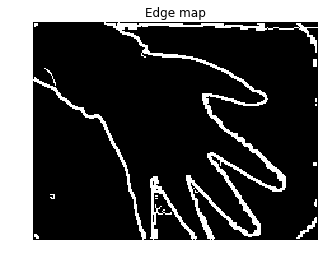

<Figure size 432x288 with 0 Axes>

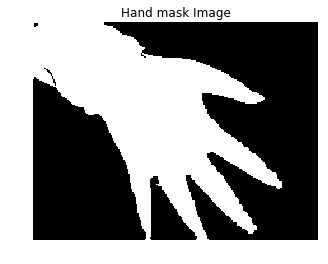

<Figure size 432x288 with 0 Axes>

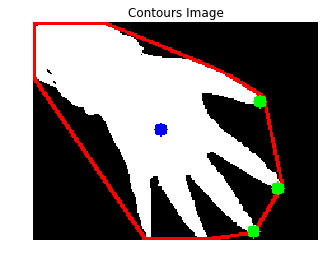

<Figure size 432x288 with 0 Axes>

3
-------------Hand Tracking---------------
centers:  [[87 85]]
new tips:  [[ 82 169]
 [171 141]
 [161  95]]

pairs [[ 0.  0.]]

pairs [[   0.            0.        ]
 [  -1.          223.04259683]
 [  -1.          188.30825792]]
hand center:  [[ 87.  85.]
 [ -1.  -1.]]
fingertips:  [[  82.  169.]
 [ 171.  141.]
 [ 161.   95.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]]
----------------------------


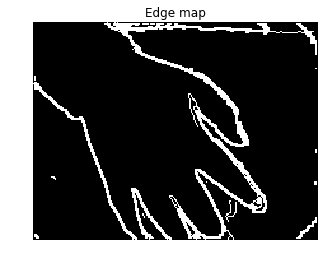

<Figure size 432x288 with 0 Axes>

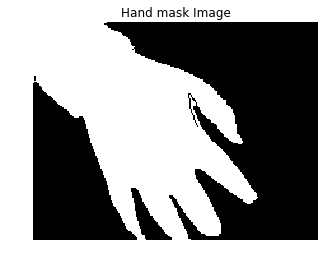

<Figure size 432x288 with 0 Axes>

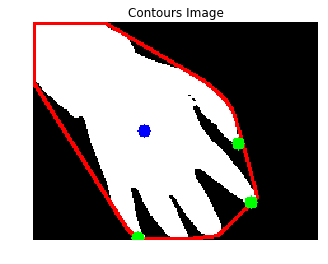

<Figure size 432x288 with 0 Axes>

2
-------------Hand Tracking---------------
centers:  [[103  88]]
new tips:  [[207 151]
 [192  72]]

pairs [[ 0.  0.]]

pairs [[   0.            0.        ]
 [  -1.          206.34437235]]
hand center:  [[ 103.   88.]
 [  -1.   -1.]]
fingertips:  [[ 207.  151.]
 [ 192.   72.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]
 [  -1.   -1.]]
----------------------------


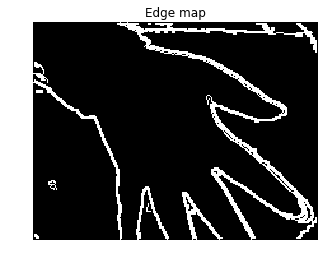

<Figure size 432x288 with 0 Axes>

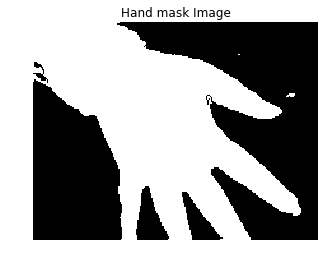

<Figure size 432x288 with 0 Axes>

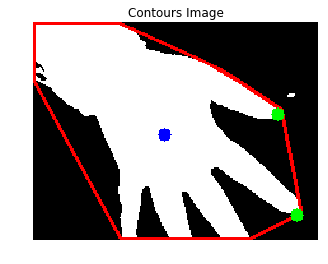

<Figure size 432x288 with 0 Axes>

In [30]:
def main ():
    parser = argparse.ArgumentParser(usage=__doc__)
    add_camera_opener_options(parser)
    parser.add_argument("--seconds", type=int, default=15, help="duration to capture data")
    options = parser.parse_args(args=['--rrf','123.rrf','--seconds', '5'])
    opener = CameraOpener(options)
    cam = opener.open_camera()

    print_camera_info (cam)
    print("isConnected", cam.isConnected())
    print("getFrameRate", cam.getFrameRate())
    print(cam.getFilterLevel())

    z_queue = queue.Queue()
    gray_queue = queue.Queue()
    points3D_queue = queue.Queue()
    ConfidenceIndex_queue = queue.Queue()
    Confidence_queue = queue.Queue()
    l = MyListener(z_queue,gray_queue,points3D_queue,ConfidenceIndex_queue,Confidence_queue)

    cam.registerDataListener(l)
    cam.startCapture()

    process_event(z_queue, gray_queue, points3D_queue, ConfidenceIndex_queue, Confidence_queue, painter=l, seconds=5)

    cam.stopCapture()
    
    
if (__name__ == "__main__"):
    main()

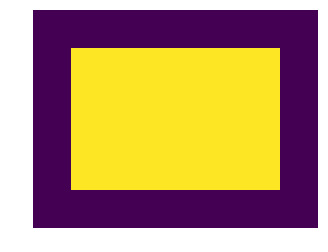

In [31]:
#show plane edge
test = np.zeros((171,224), np.uint8)
l = 30
test[l:171-l,l:224-l] = 1
plt.imshow(test),plt.axis('off')
plt.show()

In [32]:
x= [(1,1), (3, 4)]
y = [(2,2), (7,8)]
print(x[0])
print(y[0])
d = get_euclidean_distance(x[0], y[0])
print(d)

(1, 1)
(2, 2)
1.41421356237
